# Hi, This is Frank's notebook 

In [50]:
import numpy as np
from matplotlib import pyplot as plt

import datetime

import pandas as pd

## Let's do some data cleaning and ploting

In [127]:
file = '../sunspot_data/NOAA_daily_1945.txt'

data = pd.read_table(file, header=1, delim_whitespace=True)
data

,Year,Month,Day,SSN
0,1945,1,1,10.0
1,1945,1,2,0.0
2,1945,1,3,1.0
3,1945,1,4,2.0
4,1945,1,5,11.0
...,...,...,...,...
26658,2017,12,27,NaN
26659,2017,12,28,NaN
26660,2017,12,29,NaN
26661,2017,12,30,NaN


In [128]:
fmt = '%Y.%m.%d'

times = []

for index, row in data.iloc[:].iterrows():
    s = '%i.%i.%i'%(row['Year'],row['Month'],row['Day'])
    dt = datetime.datetime.strptime(s, fmt)
    times.append(dt)


In [129]:
t = Time(times,)

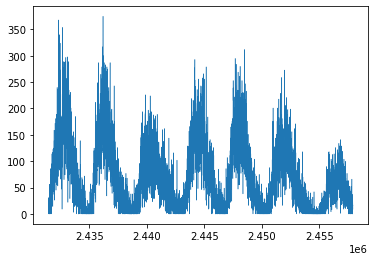

In [130]:
plt.plot(t.jd, data['SSN'], lw=0.5)

In [131]:
stacked = np.vstack((t.jd,data['SSN']))

np.savetxt('NOAA_daily_inJD.txt',stacked.T, fmt='%1.1f',header='Change date format to JD\n Julian_date SSN')

## SILSO data

In [132]:
file = '../sunspot_data/SILSO_daily_1818.csv'

silso_data = pd.read_table(file, sep=';', header=None)
silso_data

,0,1,2,3,4,5,6,7
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1
...,...,...,...,...,...,...,...,...
73865,2020,3,27,2020.236,0,0.0,43,0
73866,2020,3,28,2020.239,0,0.0,39,0
73867,2020,3,29,2020.242,0,0.0,36,0
73868,2020,3,30,2020.245,4,0.2,9,0


In [133]:
fmt = '%Y.%m.%d'

times = []

for index, row in silso_data.iloc[:].iterrows():
    s = '%i.%i.%i'%(row[0],row[1],row[2])
    dt = datetime.datetime.strptime(s, fmt)
    times.append(dt)


In [134]:
t = Time(times,)

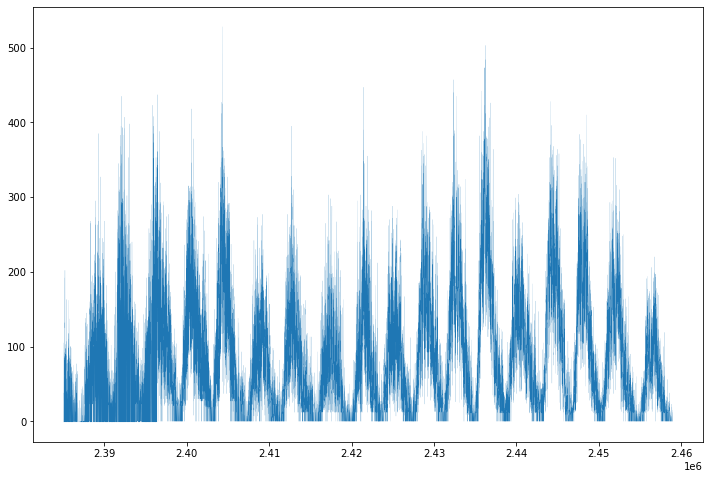

In [135]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(t.jd, silso_data[4], lw=0.1)

In [137]:
silso_stacked = np.hstack((t.jd[:, np.newaxis], silso_data.iloc[:,4:]))

header =  'Change date format to JD\n'
header += 'Julian_date SSN SSN_std observations Definitive_indicator'

np.savetxt('SILSO_daily_inJD.txt', silso_stacked, fmt='%1.1f', header=header)

## SILSO Monthly data

In [999]:
file = '../sunspot_data/SN_m_tot_V2.0.csv'

data = pd.read_table(file, sep=';', header=None)
data

,0,1,2,3,4,5,6
0,1749,1,1749.042,96.7,-1.0,-1,1
1,1749,2,1749.123,104.3,-1.0,-1,1
2,1749,3,1749.204,116.7,-1.0,-1,1
3,1749,4,1749.288,92.8,-1.0,-1,1
4,1749,5,1749.371,141.7,-1.0,-1,1
...,...,...,...,...,...,...,...
3251,2019,12,2019.958,1.5,0.5,855,1
3252,2020,1,2020.042,6.4,0.7,722,0
3253,2020,2,2020.124,0.4,0.1,853,0
3254,2020,3,2020.206,1.5,0.2,937,0


In [1000]:
fmt = '%Y.%m.%d'

times = []

for index, row in data.iloc[:].iterrows():
    s = '%i.%i.%i'%(row[0],row[1],15)
    dt = datetime.datetime.strptime(s, fmt)
    times.append(dt)
t = Time(times)

silso_monthly = np.hstack((t.jd[:, np.newaxis], data.iloc[:,2:]))

header =  'Change date format to JD\n'
header += 'Julian_date SSN SSN_std observations Definitive_indicator'

np.savetxt('SILSO_monthly_inJD.txt',silso_monthly, fmt='%1.3f', header=header)

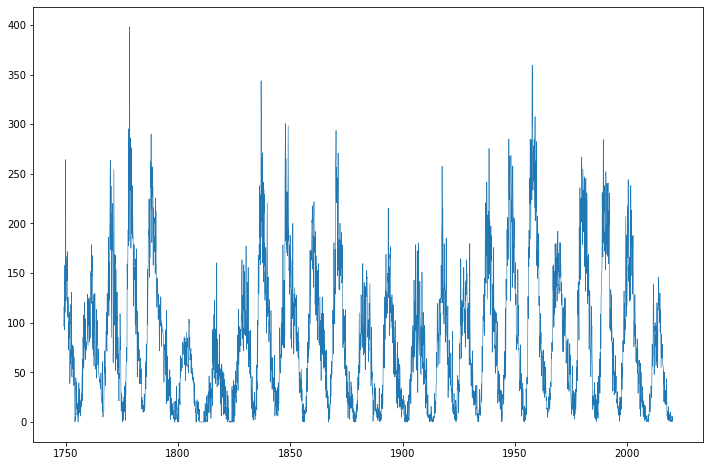

In [181]:
fig, ax = plt.subplots(figsize=(12,8))

plt.plot(data[2], data[3], lw=0.6)

## Let's try some Gaussian Processes regression

In [138]:
import george
from george import kernels
from george.modeling import Model

/Users/frank/miniconda3/envs/fds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/frank/miniconda3/envs/fds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/frank/miniconda3/envs/fds/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [1007]:
silso_monthly = np.loadtxt('SILSO_monthly_inJD.txt')

silso_monthly = silso_monthly[silso_monthly[:,3] != -1]
silso_monthly.shape

(2428, 6)

In [680]:
guess = np.array([np.log(8)])


def kernel(A,gamma,logP,m):

    # k1 = np.exp(5.9) * kernels.ExpSquaredKernel(metric=np.exp(1.7))
    k2 = A * kernels.ExpSine2Kernel(gamma=gamma,log_period=logP)* \
    kernels.ExpSquaredKernel(metric=m)
    # k3 = np.exp(5.5) * kernels.ExpSquaredKernel(metric=np.exp(-10))
    # k4 = np.exp(1) * kernels.RationalQuadraticKernel(log_alpha=np.log(0.78), metric=1.2**2)
    
    return k2 

(300, 6)


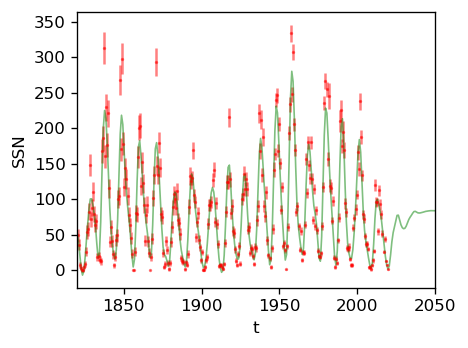

In [1076]:
# select only nth data points
nth = 8
data_select = silso_monthly[-2400::nth]
print(data_select.shape)

t = data_select[:,1]
y = data_select[:,2]
yerr = data_select[:,3]

guess = [np.exp(8.5), 1.2, np.log(11), np.exp(4.7)]

gp = george.GP(kernel=kernel(*guess), mean=np.mean(y), fit_mean=True, 
              white_noise=6.3, fit_white_noise=True)
gp.compute(t, yerr)

t_pred = np.linspace(1800,2050,300)
pred = gp.predict(y, t_pred, return_cov=False)

fig, ax = plt.subplots(figsize=(4,3), dpi=120)


plt.errorbar(t, y, yerr=yerr, fmt= 'r.',markersize=2, linestyle='None', alpha=0.5, \
             label='condition points')
plt.plot(t_pred, pred, 'g', lw=1, alpha=0.5)

plt.xlabel('t')
plt.ylabel('SSN')

plt.xlim([1820,2050])

plt.tight_layout()

plt.savefig('GP_guess.png')

plt.show()

In [1009]:
p = gp.get_parameter_vector()
print('Parameters:\n')
for para in gp.get_parameter_dict():
    print(para,':\t',gp.get_parameter_dict()[para])
print('LnL:', lnprob(p))

Parameters:

mean:value :	 83.971
white_noise:value :	 6.3
kernel:k1:k1:log_constant :	 8.5
kernel:k1:k2:gamma :	 1.2
kernel:k1:k2:log_period :	 2.3978952727983707
kernel:k2:metric:log_M_0_0 :	 4.7
LnL: -1513.1884341076081


In [1010]:
mean = np.mean(y)
std  = np.std(y)

In [1011]:
priors_lim = []

# limit for mean
priors_lim.append([mean-2*std, mean+2*std])
priors_lim.append([0.001, std])
priors_lim.append(np.log([0.05*std, 1000*std]))
priors_lim.append([0.01, 100])
priors_lim.append(np.log([8, 18]))
priors_lim.append(np.log([18, 300]))


sigmas = np.array([std/3,0.1,0.1,1,0.05,0.06])

def log_prior(p, priors_lim=priors_lim):
    for j in range(5):
        limit = priors_lim[j]
        if (p[j] < limit[0]) or (p[j] > limit[1]):
            return -np.inf
    
    return 0 #logprior.sum()

In [1012]:
def lnprob(p):    
    # Trivial uniform prior.
#     if np.any((p[:] < -100 ) + (p[:] > 300)):
#         return -np.inf
    
    gp.set_parameter_vector(p) 
    
    return gp.log_likelihood(y, quiet=True) + log_prior(p)

def plot_chains(sampler, nburn, names):
    rows = sampler.chain.shape[2]
    
    fig, ax = plt.subplots(rows, figsize=(10, 3*rows), sharex=True)
    for i in range(rows):
        ax[i].plot(sampler.chain[:, :, i].T, '-k', alpha=0.2);
        ax[i].set_ylabel(names[i])
        ax[i].grid()

In [1013]:
import emcee

initial = gp.get_parameter_vector()
ndim, nwalkers = len(initial), 32
p0 = initial + sigmas * np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

print("Running burn-in...")
p0, _, _ = sampler.run_mcmc(p0, 100, progress=True)
# sampler.reset()

# print("Running production...")
# p0, _, _ = sampler.run_mcmc(p0, 100, progress=True);

Running burn-in...


  0%|          | 0/100 [00:00<?, ?it/s]/Users/frank/miniconda3/envs/fds/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


In [1034]:
print("Running production...")
p0, _, _ = sampler.run_mcmc(p0, 300, progress=True);

Running production...


100%|██████████| 300/300 [01:12<00:00,  4.16it/s]


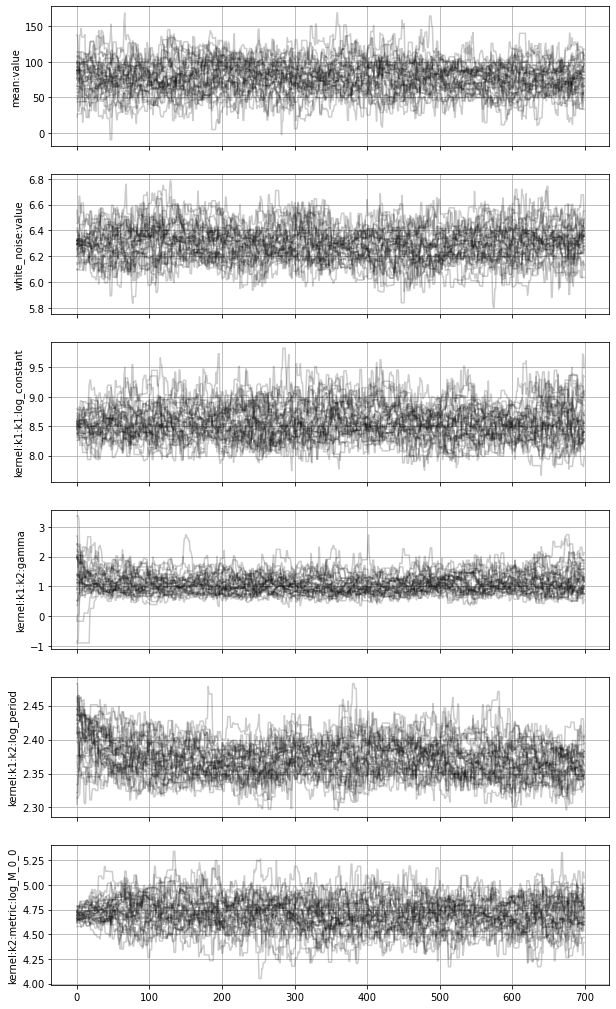

In [1051]:
names = gp.get_parameter_names()
plot_chains(sampler, 100, names)

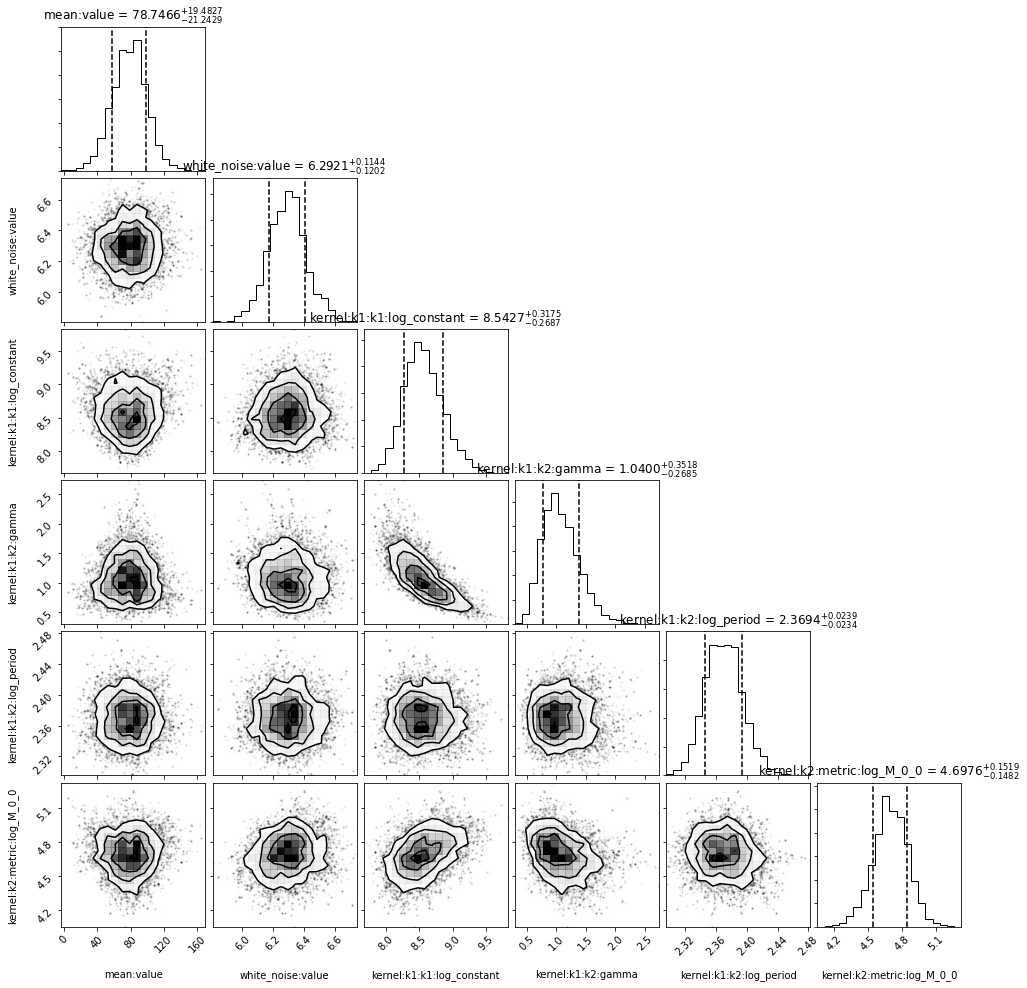

In [1052]:
import corner

samples = sampler.get_chain(discard=200, flat=True,)
corner.corner(samples, labels=names, \
              quantiles=(0.16, 0.84), title_fmt='.4f', \
              show_titles=True,)

plt.savefig('GP_corner.png')
plt.show()

In [1059]:
sampler.chain.shape

(32, 700, 6)

In [1060]:
p_bestfit = np.median(sampler.chain[:,-500:,], axis=(0,1))

print('Bestfit parameters:\n', p_bestfit)
print('LnL:', lnprob(p_bestfit))

Bestfit parameters:
 [78.74660797  6.29211911  8.54274986  1.040035    2.36937302  4.69762971]
LnL: -1512.2213534215898


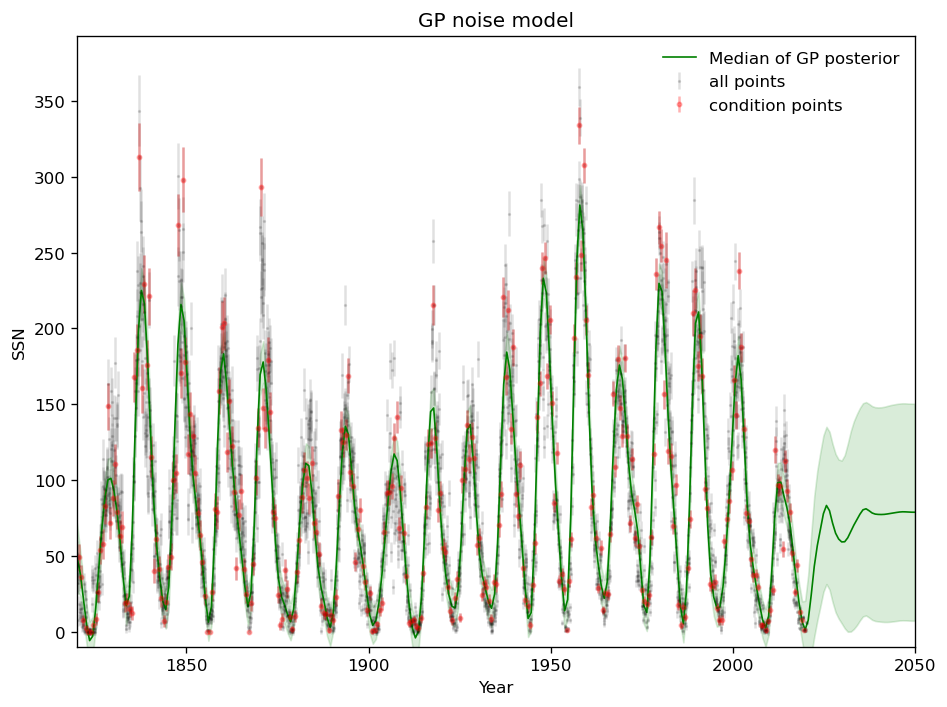

In [1062]:
# Plot the data.
fig, ax = plt.subplots(figsize=(8,6), dpi=120)

plt.errorbar(silso_monthly[:,1], silso_monthly[:,2], yerr=silso_monthly[:,3], fmt=".k", \
             markersize=2, linestyle='None', alpha=0.12, label='all points')
plt.errorbar(t, y, yerr=yerr, fmt=".r", markersize=5, linestyle='None', alpha=0.3, \
             label='condition points')

# The positions where the prediction should be computed.
x = np.linspace(1800, 2050, 300)


# samples = sampler.flatchain[-100*nwalkers:]
# mus = []
# for s in samples[np.random.randint(100, size=10)]:
#     gp.set_parameter_vector(s)
#     mu = gp.sample_conditional(y, x)
#     plt.plot(x, mu, color="b", alpha=0.05)

gp.set_parameter_vector(p_bestfit)
yfull, cov = gp.predict(y, x, return_cov=True)
err = np.sqrt(np.diag(cov))
  

plt.plot(x, yfull,c='g',lw=1,alpha=1, label='Median of GP posterior')
plt.fill_between(x, (yfull-err), (yfull+err),color='g',\
                 alpha=0.15)

plt.ylabel(r"SSN")
plt.xlabel(r"Year")

plt.xlim([1820,2050])
plt.ylim(bottom=-10)

plt.legend(frameon=0)

plt.title("GP noise model")

plt.tight_layout()

plt.savefig('GP_fit.png')
plt.show()

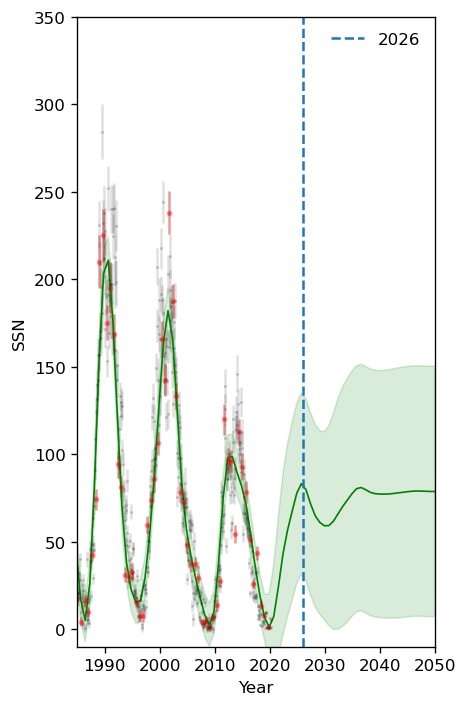

In [1065]:
# Plot the data.
fig, ax = plt.subplots(figsize=(4,6), dpi=120)

plt.errorbar(silso_monthly[:,1], silso_monthly[:,2], yerr=silso_monthly[:,3], fmt=".k", \
             markersize=2, linestyle='None', alpha=0.12,)
plt.errorbar(t, y, yerr=yerr, fmt=".r", markersize=5, linestyle='None', alpha=0.3, \
            )

# The positions where the prediction should be computed.
x = np.linspace(1800, 2050, 300)


# samples = sampler.flatchain[-100*nwalkers:]
# mus = []
# for s in samples[np.random.randint(100, size=10)]:
#     gp.set_parameter_vector(s)
#     mu = gp.sample_conditional(y, x)
#     plt.plot(x, mu, color="b", alpha=0.05)

gp.set_parameter_vector(p_bestfit)
yfull, cov = gp.predict(y, x, return_cov=True)
err = np.sqrt(np.diag(cov))
  

plt.plot(x, yfull,c='g',lw=1,alpha=1, )
plt.fill_between(x, (yfull-err), (yfull+err),color='g',\
                 alpha=0.15)

plt.axvline(x=2026, ls='--',label='2026')

plt.ylabel(r"SSN")
plt.xlabel(r"Year")

plt.xlim([1985,2050])
plt.ylim(bottom=-10,top=350)

plt.legend(frameon=0)

plt.tight_layout()

plt.savefig('GP_fit_zoomin.png')
plt.show()